In [1]:
# import libraries
import numpy as np
import sys
import psi4
from helper_PFCI import PFHamiltonianGenerator
np.set_printoptions(threshold=sys.maxsize)
import scipy
from scipy.optimize import curve_fit
from scipy import interpolate
from matplotlib import pyplot as plt
import matplotlib
from scipy import constants
from numpy.polynomial import Polynomial
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
import seaborn as sns
import pandas as pd

In [2]:
import os
print(os.path.abspath("."))

/Users/ptolley1/Documents/GitHub/SCQED-PCQED/src


In [3]:
#calculate some constants for LiH

amu_to_au = 1822.89


mA_kg = 1.00784 * (10 ** (-3) / (6.022 * 10 ** 23) )
mB_kg = 6.9410 * (10 ** (-3) / (6.022 * 10 ** 23) )
mA_au = 1.00784 * amu_to_au
mB_au = 6.9410 * amu_to_au
mu_au = (mA_au * mB_au )/ (mA_au + mB_au)
mu_kg = (mA_kg * mB_kg) / (mA_kg + mB_kg)  
print("mu_au: ", mu_au)

mu_au:  1604.2437006156372


In [4]:
"""
def declutter_E_array(E_array, delta=0.002, num_to_declutter = 6):


    E_array = np.copy(E_array)
    new_E_array = np.zeros_like(E_array)

    for i in range(0,num_to_declutter):
        previous_intersection = 0
        for z in range(0,200):
            for j in range(i+1, E_array.shape[1]):
                array1 = E_array[:, i]
                array2 = E_array[:, j]

                #find closest points
                idx =(np.abs(array1[previous_intersection:] - array2[previous_intersection:])).argmin() + previous_intersection


                #assume they crossover if they get really close
                if np.abs(array1[idx]- array2[idx]) < delta:
                        
                    #copy one of the arrays
                    array1_copy = np.array(array1, copy=True)

                    array1 = np.concatenate([array1[:idx],  array2[idx:]])
                    array2 =np.concatenate([array2[:idx] , array1_copy[idx:]])


                    E_array[:,i] = array1
                    E_array[:,j] = array2

                previous_intersection = idx

        new_E_array[:,i ] = E_array[:,i]

    return new_E_array
"""

'\ndef declutter_E_array(E_array, delta=0.002, num_to_declutter = 6):\n\n\n    E_array = np.copy(E_array)\n    new_E_array = np.zeros_like(E_array)\n\n    for i in range(0,num_to_declutter):\n        previous_intersection = 0\n        for z in range(0,200):\n            for j in range(i+1, E_array.shape[1]):\n                array1 = E_array[:, i]\n                array2 = E_array[:, j]\n\n                #find closest points\n                idx =(np.abs(array1[previous_intersection:] - array2[previous_intersection:])).argmin() + previous_intersection\n\n\n                #assume they crossover if they get really close\n                if np.abs(array1[idx]- array2[idx]) < delta:\n                        \n                    #copy one of the arrays\n                    array1_copy = np.array(array1, copy=True)\n\n                    array1 = np.concatenate([array1[:idx],  array2[idx:]])\n                    array2 =np.concatenate([array2[:idx] , array1_copy[idx:]])\n\n\n             

In [5]:
def declutter_E_array(E_array, discontinuity_threshold=0.0001, energy_diff_threshold = 0.02,  num_to_declutter = 2):

    E_array = np.copy(E_array)
    new_E_array = np.zeros_like(E_array)

    for i in range(0,num_to_declutter):
        previous_intersection = 0
        for z in range(0,50):
            for j in range(i+1, E_array.shape[1]):
                array1 = E_array[:, i]
                array2 = E_array[:, j]

                array1_from_previous_intersection = array1[previous_intersection:]
                array2_from_previous_intersection = array2[previous_intersection:]


                #find closest points
                closest_indices =np.where(np.abs(array1[previous_intersection:] - array2[previous_intersection:]) < energy_diff_threshold)
                if np.shape(closest_indices)[1] != 0:
                    #print(i)
                    #print(closest_indices)
                    pass


                try:
                    dy_1 = np.gradient(array1_from_previous_intersection)
                    idx_1 = np.where(abs(np.diff(dy_1)) >  discontinuity_threshold)[0]+1

                    dy_2= np.gradient(array2_from_previous_intersection)
                    idx_2 = np.where(abs(np.diff(dy_2)) > discontinuity_threshold)[0]+1

                    if (len(idx_1)!= 0 and len(idx_2) != 0 ):

                        mask_idx1_idx2 = np.isin(idx_1, idx_2)
                        indices_idx1_in_idx2 = np.where(mask_idx1_idx2)[0]
                        indices_idx1_in_idx2 = idx_1[indices_idx1_in_idx2]
                        #print(indices_idx1_in_idx2)


                        starting_index=0
                        for elem_index in range(len(indices_idx1_in_idx2)-1):
                            if indices_idx1_in_idx2[elem_index]+1 == indices_idx1_in_idx2[elem_index+1]:
                                starting_index = elem_index+1
                        indices_idx1_in_idx2 = indices_idx1_in_idx2[starting_index:]
                        
                            
                        

                        if(len(indices_idx1_in_idx2) != 0 ):

                            mask_discontinuties_energydiff = np.isin(indices_idx1_in_idx2, closest_indices)
                            indices_discontinuties_in_energydiff = np.where(mask_discontinuties_energydiff)[0]
                            #print(indices_discontinuties_in_energydiff)

                            if len(indices_discontinuties_in_energydiff) != 0 :

                                idx = indices_idx1_in_idx2[indices_discontinuties_in_energydiff[0]]+ previous_intersection
                                #print(idx)

                                array1_copy = np.array(array1, copy=True)

                                array1 = np.concatenate([array1[:idx],  array2[idx:]])
                                array2 =np.concatenate([array2[:idx] , array1_copy[idx:]])


                                E_array[:,i] = array1
                                E_array[:,j] = array2


                                previous_intersection = idx
                except():
                    print(i)

        new_E_array[:,i ] = E_array[:,i]

    return new_E_array

In [6]:
import warnings
def declutter_E_array(E_array, r_data, discontinuity_threshold_std = 1, energy_diff_threshold_std = 2,  num_to_declutter = 2):
    E_array = np.copy(E_array)
    new_E_array = np.zeros_like(E_array)
    for i in range(0,num_to_declutter):
        previous_intersection = 0
        for z in range(0,50):
            for j in range(i+1, E_array.shape[1]):
                array1 = E_array[:, i]
                array2 = E_array[:, j]
                #Only want array from previous intersection so it doesnt get recrossed
                array1_from_previous_intersection = array1[previous_intersection:]
                array2_from_previous_intersection = array2[previous_intersection:]
                #trying to determine how close two energy surfaces get, if they get very close this some evidence that they crossover
                diff_array1 = np.diff(array1_from_previous_intersection)
                diff_array2 = np.diff(array2_from_previous_intersection)
                std1 = np.std(np.abs(diff_array1))
                mean1 = np.mean(np.abs(diff_array1))
                std2 = np.std(np.abs(diff_array2))
                mean2 = np.mean(np.abs(diff_array2))
                energy_diff_threshold = ((mean1 + mean2)/2) + (((std1+std2)/2) * energy_diff_threshold_std)
                #find closest points
                #print(np.abs(np.abs(array1[previous_intersection:]) - np.abs(array2[previous_intersection:])))
                closest_indices =np.where(np.abs(np.abs(array1[previous_intersection:]) - np.abs(array2[previous_intersection:])) < energy_diff_threshold)
                try:
                    #use discontinuties in second derivative, discontinutities defined using standard deviation
                    dy_1 = np.abs(np.gradient(np.gradient(array1_from_previous_intersection, r_data[previous_intersection:], edge_order = 1), r_data[previous_intersection:], edge_order = 1))
                    std = np.std(abs(np.diff(dy_1)))
                    mean = np.mean(abs(np.diff(dy_1)))
                    discontinuity_threshold =  mean + (std*discontinuity_threshold_std)
                    idx_1 = np.where(abs(np.diff(dy_1)) >  discontinuity_threshold)[0]+2
                    dy_2= np.abs(np.gradient(np.gradient(array2_from_previous_intersection, r_data[previous_intersection:], edge_order=1), r_data[previous_intersection:], edge_order=1))
                    std = np.std(abs(np.diff(dy_2)))
                    mean = np.mean(abs(np.diff(dy_2)))
                    discontinuity_threshold =  mean + (std*discontinuity_threshold_std)
                    idx_2 = np.where(abs(np.diff(dy_2)) > discontinuity_threshold)[0]+2
                    if (len(idx_1)!= 0 and len(idx_2) != 0 ):
                        mask_idx1_idx2 = np.isin(idx_1, idx_2)
                        indices_idx1_in_idx2 = np.where(mask_idx1_idx2)[0]
                        indices_idx1_in_idx2 = idx_1[indices_idx1_in_idx2]
                        # indices_idx1_in_idx2  = indices_idx1_in_idx2[ending_index:]
                        # starting_index=ending_index
                        # ending_index = starting_index
                        starting_index = 0
                        ending_index = 0
                        for elem_index in range(len(indices_idx1_in_idx2)-1):
                            #print("ayo: ", abs((indices_idx1_in_idx2[elem_index]) - (indices_idx1_in_idx2[elem_index+1])))
                            if abs((indices_idx1_in_idx2[elem_index]) - (indices_idx1_in_idx2[elem_index+1])) < 25 :
                                ending_index = ending_index+1
                            else:
                                break
                        indices_idx1_in_idx2 = indices_idx1_in_idx2[starting_index:ending_index]
                        if(len(indices_idx1_in_idx2) != 0 ):
                            mask_discontinuties_energydiff = np.isin(indices_idx1_in_idx2, closest_indices)
                            indices_discontinuties_in_energydiff = np.where(mask_discontinuties_energydiff)[0]
                            #print(indices_discontinuties_in_energydiff)
                            #print(indices_discontinuties_in_energydiff)
                            if len(indices_discontinuties_in_energydiff) != 0 :
                                for k in range(len(indices_discontinuties_in_energydiff) - 1):
                                    idx = indices_idx1_in_idx2[indices_discontinuties_in_energydiff[k]]+ previous_intersection
                                    #print(idx)
                                    array1_copy = np.array(array1, copy=True)
                                    array1 = np.concatenate([array1[:idx],  array2[idx:idx+1], array1[idx+1:]])
                                    array2 = np.concatenate([array2[:idx] , array1_copy[idx:idx+1], array2[idx+1:]])
                                    E_array[:,i] = array1
                                    E_array[:,j] = array2
                                idx = indices_idx1_in_idx2[indices_discontinuties_in_energydiff[-1]]+ previous_intersection
                                #print(idx)
                                array1_copy = np.array(array1, copy=True)
                                array1 = np.concatenate([array1[:idx],  array2[idx:]])
                                array2 =np.concatenate([array2[:idx] , array1_copy[idx:]])
                                #print(indices_idx1_in_idx2)
                                fitting_distance=10
                                if abs(indices_idx1_in_idx2[-1] - indices_idx1_in_idx2[0]) < fitting_distance:
                                    array1 = array1.tolist()
                                    array2 = array2.tolist()
                                    r_data_list = r_data.tolist()
                                    #fitting region
                                    end_discontinuity = indices_idx1_in_idx2[indices_discontinuties_in_energydiff[-1]]+ previous_intersection
                                    start_discontinuity = indices_idx1_in_idx2[indices_discontinuties_in_energydiff[0]]+ previous_intersection
                                    fit_E_data_end = min(end_discontinuity+fitting_distance, len(array1))
                                    fit_E_data_start= max(start_discontinuity-fitting_distance, 0)
                                    # print(fit_E_data_start)
                                    # print(fit_E_data_end)
                                    fitting_E_data = array1[fit_E_data_start: start_discontinuity] + array1[end_discontinuity: fit_E_data_end]
                                    fitting_r_data = r_data_list[fit_E_data_start: start_discontinuity] + r_data_list[end_discontinuity:fit_E_data_end]
                                    with warnings.catch_warnings():
                                        warnings.simplefilter("ignore")
                                        poly = np.poly1d(np.polyfit(fitting_r_data, fitting_E_data, 12))
                                    r_data_fitting_list =  r_data_list[fit_E_data_start:fit_E_data_end]
                                    polyvals = np.polyval(np.asarray(poly),r_data_fitting_list )
                                    array1 = array1[:fit_E_data_start] + polyvals.tolist() + array1[fit_E_data_end:]
                                    fitting_E_data = array2[fit_E_data_start: start_discontinuity] + array2[end_discontinuity: fit_E_data_end]
                                    fitting_r_data = r_data_list[fit_E_data_start: start_discontinuity] + r_data_list[end_discontinuity:fit_E_data_end]
                                    with warnings.catch_warnings():
                                        warnings.simplefilter("ignore")
                                        poly = np.poly1d(np.polyfit(fitting_r_data, fitting_E_data, 12))
                                    r_data_fitting_list =  r_data_list[fit_E_data_start:fit_E_data_end]
                                    polyvals = np.polyval(np.asarray(poly),r_data_fitting_list )
                                    array2 = array2[:fit_E_data_start] + polyvals.tolist() + array2[fit_E_data_end:]
                                E_array[:,i] = array1
                                E_array[:,j] = array2
                                previous_intersection = idx
                except():
                    print("uh oh")
        new_E_array[:,i ] = E_array[:,i]
    return new_E_array

In [ ]:
import warnings
def declutter_E_array(E_array, dipoles,  r_data, discontinuity_threshold_std = 1, energy_diff_threshold_std = 2,  num_to_declutter = 2):
    E_array = np.copy(E_array)
    new_E_array = np.zeros_like(E_array)
    dipoles = np.copy(dipoles)
    new_dipoles = np.zeros_like(dipoles)


    #dipole discontinuities
    for i in range(0,num_to_declutter):
        previous_intersection = 0
        for z in range(0,50):
            for j in range(i+1, E_array.shape[1]):
                array1 = E_array[:, i]
                array2 = E_array[:, j]

                dipole_array1 = dipoles[:, i] [previous_intersection:]
                dipole_array2 = dipoles[:, j] [previous_intersection:]


                #Only want array from previous intersection so it doesnt get recrossed
                array1_from_previous_intersection = array1[previous_intersection:]
                array2_from_previous_intersection = array2[previous_intersection:]
                #trying to determine how close two energy surfaces get, if they get very close this some evidence that they crossover
                diff_array1 = np.diff(array1_from_previous_intersection)
                diff_array2 = np.diff(array2_from_previous_intersection)
                std1 = np.std(np.abs(diff_array1))
                mean1 = np.mean(np.abs(diff_array1))
                std2 = np.std(np.abs(diff_array2))
                mean2 = np.mean(np.abs(diff_array2))
                energy_diff_threshold = ((mean1 + mean2)/2) + (((std1+std2)/2) * energy_diff_threshold_std)
                #find closest points
                #print(np.abs(np.abs(array1[previous_intersection:]) - np.abs(array2[previous_intersection:])))
                closest_indices =np.where(np.abs(np.abs(array1[previous_intersection:]) - np.abs(array2[previous_intersection:])) < energy_diff_threshold)
                try:

                    #if energies are close and there are two matcjhing discontinuities in dipole arrary 
                    dipoles_diff_1 = np.diff(dipole_array1)
                    dipoles_diff_2 = np.diff(dipole_array2)

                    mean_1 = np.mean(dipoles_diff_1)
                    mean_2 = np.mean(dipoles_diff_2)

                    std_1 = np.std(dipoles_diff_1)
                    std_2 = np.std(dipoles_diff_2)
                    discontinuity_threshold_pos =  mean_1 + (std_1*discontinuity_threshold_std)
                    discontinuity_threshold_neg =  mean_1 - (std_1*discontinuity_threshold_std)
                    idx_1 = np.sort(np.concatenate([ np.where( dipoles_diff_1 >  discontinuity_threshold_pos )[0]+1 ,  np.where( dipoles_diff_1 <  discontinuity_threshold_neg )[0]+1 ]))

                    discontinuity_threshold_pos =  mean_2 + (std_2*discontinuity_threshold_std)
                    discontinuity_threshold_neg =  mean_2 - (std_2*discontinuity_threshold_std)
                    idx_2 = np.sort(np.concatenate([ np.where( dipoles_diff_2 >  discontinuity_threshold_pos )[0]+1 ,  np.where( dipoles_diff_2 <  discontinuity_threshold_neg )[0]+1 ]))



                    if (len(idx_1)!= 0 and len(idx_2) != 0 ):
                        mask_idx1_idx2 = np.isin(idx_1, idx_2)
                        indices_idx1_in_idx2 = np.where(mask_idx1_idx2)[0]
                        indices_idx1_in_idx2 = idx_1[indices_idx1_in_idx2]

                        
                        if(len(indices_idx1_in_idx2) != 0 ):
                            mask_discontinuties_energydiff = np.isin(indices_idx1_in_idx2, closest_indices)
                            indices_discontinuties_in_energydiff = np.where(mask_discontinuties_energydiff)[0]

                            if len(indices_discontinuties_in_energydiff) != 0 :
                                for k in range(len(indices_discontinuties_in_energydiff) - 1):
                                    idx = indices_idx1_in_idx2[indices_discontinuties_in_energydiff[k]]+ previous_intersection
                                    #print(idx)
                                    array1_copy = np.array(array1, copy=True)
                                    array1 = np.concatenate([array1[:idx],  array2[idx:idx+1], array1[idx+1:]])
                                    array2 = np.concatenate([array2[:idx] , array1_copy[idx:idx+1], array2[idx+1:]])
                                    E_array[:,i] = array1
                                    E_array[:,j] = array2
                                idx = indices_idx1_in_idx2[indices_discontinuties_in_energydiff[-1]]+ previous_intersection
                                #print(idx)
                                array1_copy = np.array(array1, copy=True)
                                array1 = np.concatenate([array1[:idx],  array2[idx:]])
                                array2 =np.concatenate([array2[:idx] , array1_copy[idx:]])
                                #print(indices_idx1_in_idx2)
                                fitting_distance=10
                                if abs(indices_idx1_in_idx2[-1] - indices_idx1_in_idx2[0]) < fitting_distance:
                                    array1 = array1.tolist()
                                    array2 = array2.tolist()
                                    r_data_list = r_data.tolist()
                                    #fitting region
                                    end_discontinuity = indices_idx1_in_idx2[indices_discontinuties_in_energydiff[0]]+ previous_intersection -1
                                    start_discontinuity = indices_idx1_in_idx2[indices_discontinuties_in_energydiff[0]]+ previous_intersection+1
                                    fit_E_data_end = min(end_discontinuity+fitting_distance, len(array1))
                                    fit_E_data_start= max(start_discontinuity-fitting_distance, 0)
                                    # print(fit_E_data_start)
                                    # print(fit_E_data_end)
                                    fitting_E_data = array1[fit_E_data_start: start_discontinuity] + array1[end_discontinuity: fit_E_data_end]
                                    fitting_r_data = r_data_list[fit_E_data_start: start_discontinuity] + r_data_list[end_discontinuity:fit_E_data_end]
                                    with warnings.catch_warnings():
                                        warnings.simplefilter("ignore")
                                        poly = np.poly1d(np.polyfit(fitting_r_data, fitting_E_data, 12))
                                    r_data_fitting_list =  r_data_list[fit_E_data_start:fit_E_data_end]
                                    polyvals = np.polyval(np.asarray(poly),r_data_fitting_list )
                                    array1 = array1[:fit_E_data_start] + polyvals.tolist() + array1[fit_E_data_end:]
                                    fitting_E_data = array2[fit_E_data_start: start_discontinuity] + array2[end_discontinuity: fit_E_data_end]
                                    fitting_r_data = r_data_list[fit_E_data_start: start_discontinuity] + r_data_list[end_discontinuity:fit_E_data_end]
                                    with warnings.catch_warnings():
                                        warnings.simplefilter("ignore")
                                        poly = np.poly1d(np.polyfit(fitting_r_data, fitting_E_data, 12))
                                    r_data_fitting_list =  r_data_list[fit_E_data_start:fit_E_data_end]
                                    polyvals = np.polyval(np.asarray(poly),r_data_fitting_list )
                                    array2 = array2[:fit_E_data_start] + polyvals.tolist() + array2[fit_E_data_end:]


                                    #dipoles
                                    ####
                                    dipole_array1 = dipole_array1.tolist()
                                    dipole_array2 = dipole_array2.tolist()
                                    r_data_list = r_data.tolist()

                                    fit_E_data_end = min(end_discontinuity+fitting_distance, len(dipole_array1))
                                    fit_E_data_start= max(start_discontinuity-fitting_distance, 0)
                                    # print(fit_E_data_start)
                                    # print(fit_E_data_end)
                                    fitting_E_data = dipole_array1[fit_E_data_start: start_discontinuity] + dipole_array1[end_discontinuity: fit_E_data_end]
                                    fitting_r_data = r_data_list[fit_E_data_start: start_discontinuity] + r_data_list[end_discontinuity:fit_E_data_end]
                                    with warnings.catch_warnings():
                                        warnings.simplefilter("ignore")
                                        poly = np.poly1d(np.polyfit(fitting_r_data, fitting_E_data, 12))
                                    r_data_fitting_list =  r_data_list[fit_E_data_start:fit_E_data_end]
                                    polyvals = np.polyval(np.asarray(poly),r_data_fitting_list )
                                    dipole_array1 = dipole_array1[:fit_E_data_start] + polyvals.tolist() + dipole_array1[fit_E_data_end:]
                                    fitting_E_data = dipole_array2[fit_E_data_start: start_discontinuity] + dipole_array2[end_discontinuity: fit_E_data_end]
                                    fitting_r_data = r_data_list[fit_E_data_start: start_discontinuity] + r_data_list[end_discontinuity:fit_E_data_end]
                                    with warnings.catch_warnings():
                                        warnings.simplefilter("ignore")
                                        poly = np.poly1d(np.polyfit(fitting_r_data, fitting_E_data, 12))
                                    r_data_fitting_list =  r_data_list[fit_E_data_start:fit_E_data_end]
                                    polyvals = np.polyval(np.asarray(poly),r_data_fitting_list )
                                    dipole_array2 = dipole_array2[:fit_E_data_start] + polyvals.tolist() + dipole_array2[fit_E_data_end:]
                                    ####



                                dipoles[:,i] = dipole_array1
                                dipoles[:,j] = dipole_array2
                                E_array[:,i] = array1
                                E_array[:,j] = array2
                                previous_intersection = idx+1
                except():
                    print("uh oh")
        new_E_array[:,i ] = E_array[:,i]
        new_dipoles[:,i ] = dipoles[:, i]

    plt.plot(r_data, new_dipoles )
    plt.show()

    #E_array = np.copy(new_E_array)
    #new_E_array = np.zeros_like(E_array)


    # for i in range(0,num_to_declutter):
    #     previous_intersection = 0
    #     for z in range(0,50):
    #         for j in range(i+1, E_array.shape[1]):
    #             array1 = E_array[:, i]
    #             array2 = E_array[:, j]
    #             #Only want array from previous intersection so it doesnt get recrossed
    #             array1_from_previous_intersection = array1[previous_intersection:]
    #             array2_from_previous_intersection = array2[previous_intersection:]
    #             #trying to determine how close two energy surfaces get, if they get very close this some evidence that they crossover
    #             diff_array1 = np.diff(array1_from_previous_intersection)
    #             diff_array2 = np.diff(array2_from_previous_intersection)
    #             std1 = np.std(np.abs(diff_array1))
    #             mean1 = np.mean(np.abs(diff_array1))
    #             std2 = np.std(np.abs(diff_array2))
    #             mean2 = np.mean(np.abs(diff_array2))
    #             energy_diff_threshold = ((mean1 + mean2)/2) + (((std1+std2)/2) * energy_diff_threshold_std)
    #             #find closest points
    #             #print(np.abs(np.abs(array1[previous_intersection:]) - np.abs(array2[previous_intersection:])))
    #             closest_indices =np.where(np.abs(np.abs(array1[previous_intersection:]) - np.abs(array2[previous_intersection:])) < energy_diff_threshold)
    #             try:
    #                 #use discontinuties in second derivative, discontinutities defined using standard deviation
    #                 dy_1 = np.abs(np.gradient(np.gradient(array1_from_previous_intersection, r_data[previous_intersection:], edge_order = 1), r_data[previous_intersection:], edge_order = 1))
    #                 std = np.std(abs(np.diff(dy_1)))
    #                 mean = np.mean(abs(np.diff(dy_1)))
    #                 discontinuity_threshold =  mean + (std*discontinuity_threshold_std)
    #                 idx_1 = np.where(abs(np.diff(dy_1)) >  discontinuity_threshold)[0]+2
    #                 dy_2= np.abs(np.gradient(np.gradient(array2_from_previous_intersection, r_data[previous_intersection:], edge_order=1), r_data[previous_intersection:], edge_order=1))
    #                 std = np.std(abs(np.diff(dy_2)))
    #                 mean = np.mean(abs(np.diff(dy_2)))
    #                 discontinuity_threshold =  mean + (std*discontinuity_threshold_std)
    #                 idx_2 = np.where(abs(np.diff(dy_2)) > discontinuity_threshold)[0]+2
    #                 if (len(idx_1)!= 0 and len(idx_2) != 0 ):
    #                     mask_idx1_idx2 = np.isin(idx_1, idx_2)
    #                     indices_idx1_in_idx2 = np.where(mask_idx1_idx2)[0]
    #                     indices_idx1_in_idx2 = idx_1[indices_idx1_in_idx2]
    #                     # indices_idx1_in_idx2  = indices_idx1_in_idx2[ending_index:]
    #                     # starting_index=ending_index
    #                     # ending_index = starting_index
    #                     starting_index = 0
    #                     ending_index = 0
    #                     for elem_index in range(len(indices_idx1_in_idx2)-1):
    #                         #print("ayo: ", abs((indices_idx1_in_idx2[elem_index]) - (indices_idx1_in_idx2[elem_index+1])))
    #                         if abs((indices_idx1_in_idx2[elem_index]) - (indices_idx1_in_idx2[elem_index+1])) < 25 :
    #                             ending_index = ending_index+1
    #                         else:
    #                             break
    #                     indices_idx1_in_idx2 = indices_idx1_in_idx2[starting_index:ending_index]
    #                     if(len(indices_idx1_in_idx2) != 0 ):
    #                         mask_discontinuties_energydiff = np.isin(indices_idx1_in_idx2, closest_indices)
    #                         indices_discontinuties_in_energydiff = np.where(mask_discontinuties_energydiff)[0]
    #                         #print(indices_discontinuties_in_energydiff)
    #                         #print(indices_discontinuties_in_energydiff)
    #                         if len(indices_discontinuties_in_energydiff) != 0 :
    #                             for k in range(len(indices_discontinuties_in_energydiff) - 1):
    #                                 idx = indices_idx1_in_idx2[indices_discontinuties_in_energydiff[k]]+ previous_intersection
    #                                 #print(idx)
    #                                 array1_copy = np.array(array1, copy=True)
    #                                 array1 = np.concatenate([array1[:idx],  array2[idx:idx+1], array1[idx+1:]])
    #                                 array2 = np.concatenate([array2[:idx] , array1_copy[idx:idx+1], array2[idx+1:]])
    #                                 E_array[:,i] = array1
    #                                 E_array[:,j] = array2
    #                             idx = indices_idx1_in_idx2[indices_discontinuties_in_energydiff[-1]]+ previous_intersection
    #                             #print(idx)
    #                             array1_copy = np.array(array1, copy=True)
    #                             array1 = np.concatenate([array1[:idx],  array2[idx:]])
    #                             array2 =np.concatenate([array2[:idx] , array1_copy[idx:]])
    #                             #print(indices_idx1_in_idx2)
    #                             fitting_distance=10
    #                             if abs(indices_idx1_in_idx2[-1] - indices_idx1_in_idx2[0]) < fitting_distance:
    #                                 array1 = array1.tolist()
    #                                 array2 = array2.tolist()
    #                                 r_data_list = r_data.tolist()
    #                                 #fitting region
    #                                 end_discontinuity = indices_idx1_in_idx2[indices_discontinuties_in_energydiff[-1]]+ previous_intersection
    #                                 start_discontinuity = indices_idx1_in_idx2[indices_discontinuties_in_energydiff[0]]+ previous_intersection
    #                                 fit_E_data_end = min(end_discontinuity+fitting_distance, len(array1))
    #                                 fit_E_data_start= max(start_discontinuity-fitting_distance, 0)
    #                                 # print(fit_E_data_start)
    #                                 # print(fit_E_data_end)
    #                                 fitting_E_data = array1[fit_E_data_start: start_discontinuity] + array1[end_discontinuity: fit_E_data_end]
    #                                 fitting_r_data = r_data_list[fit_E_data_start: start_discontinuity] + r_data_list[end_discontinuity:fit_E_data_end]
    #                                 with warnings.catch_warnings():
    #                                     warnings.simplefilter("ignore")
    #                                     poly = np.poly1d(np.polyfit(fitting_r_data, fitting_E_data, 12))
    #                                 r_data_fitting_list =  r_data_list[fit_E_data_start:fit_E_data_end]
    #                                 polyvals = np.polyval(np.asarray(poly),r_data_fitting_list )
    #                                 array1 = array1[:fit_E_data_start] + polyvals.tolist() + array1[fit_E_data_end:]
    #                                 fitting_E_data = array2[fit_E_data_start: start_discontinuity] + array2[end_discontinuity: fit_E_data_end]
    #                                 fitting_r_data = r_data_list[fit_E_data_start: start_discontinuity] + r_data_list[end_discontinuity:fit_E_data_end]
    #                                 with warnings.catch_warnings():
    #                                     warnings.simplefilter("ignore")
    #                                     poly = np.poly1d(np.polyfit(fitting_r_data, fitting_E_data, 12))
    #                                 r_data_fitting_list =  r_data_list[fit_E_data_start:fit_E_data_end]
    #                                 polyvals = np.polyval(np.asarray(poly),r_data_fitting_list )
    #                                 array2 = array2[:fit_E_data_start] + polyvals.tolist() + array2[fit_E_data_end:]
    #                             E_array[:,i] = array1
    #                             E_array[:,j] = array2
    #                             previous_intersection = idx
    #             except():
    #                 print("uh oh")
    #     new_E_array[:,i ] = E_array[:,i]
    



    return new_E_array

In [ ]:
import warnings
def declutter_E_array(E_array, dipoles,  r_data, discontinuity_threshold_std = 1, energy_diff_threshold_std = 2,  num_to_declutter = 2):


    #dipole array orderd as [numroots][numroots][dipole vector][bondlength]
    E_array = np.copy(E_array)
    new_E_array = np.zeros_like(E_array)


    d_reshaped= np.zeros_like(E_array)

    def vector_magnitude(vector):
        return np.sqrt(vector[0]**2 + vector[1]**2 + vector[2]**2)


    for q in range(dipoles.shape[3]):
        for i in range(dipoles.shape[0]):
            for j in range(dipoles.shape[1]):
                if i == j:
                    d_reshaped[q][i] = vector_magnitude(dipoles[i,i,:,q])


    dipoles = np.copy(d_reshaped)
    new_dipoles = np.zeros_like(dipoles)




    #dipole discontinuities
    for i in range(0,num_to_declutter):
        previous_intersection = 0
        for z in range(0,50):
            for j in range(i+1, E_array.shape[1]):
                array1 = E_array[:, i]
                array2 = E_array[:, j]

                dipole_array1 = dipoles[:, i] [previous_intersection:]
                dipole_array2 = dipoles[:, j] [previous_intersection:]


                #Only want array from previous intersection so it doesnt get recrossed
                array1_from_previous_intersection = array1[previous_intersection:]
                array2_from_previous_intersection = array2[previous_intersection:]
                #trying to determine how close two energy surfaces get, if they get very close this some evidence that they crossover
                diff_array1 = np.diff(array1_from_previous_intersection)
                diff_array2 = np.diff(array2_from_previous_intersection)
                std1 = np.std(np.abs(diff_array1))
                mean1 = np.mean(np.abs(diff_array1))
                std2 = np.std(np.abs(diff_array2))
                mean2 = np.mean(np.abs(diff_array2))
                energy_diff_threshold = ((mean1 + mean2)/2) + (((std1+std2)/2) * energy_diff_threshold_std)
                #find closest points
                #print(np.abs(np.abs(array1[previous_intersection:]) - np.abs(array2[previous_intersection:])))
                closest_indices =np.where(np.abs(np.abs(array1[previous_intersection:]) - np.abs(array2[previous_intersection:])) < energy_diff_threshold)
                try:

                    #if energies are close and there are two matcjhing discontinuities in dipole arrary 
                    dipoles_diff_1 = np.diff(dipole_array1)
                    dipoles_diff_2 = np.diff(dipole_array2)

                    mean_1 = np.mean(dipoles_diff_1)
                    mean_2 = np.mean(dipoles_diff_2)

                    std_1 = np.std(dipoles_diff_1)
                    std_2 = np.std(dipoles_diff_2)
                    discontinuity_threshold_pos =  mean_1 + (std_1*discontinuity_threshold_std)
                    discontinuity_threshold_neg =  mean_1 - (std_1*discontinuity_threshold_std)
                    idx_1 = np.sort(np.concatenate([ np.where( dipoles_diff_1 >  discontinuity_threshold_pos )[0]+1 ,  np.where( dipoles_diff_1 <  discontinuity_threshold_neg )[0]+1 ]))

                    discontinuity_threshold_pos =  mean_2 + (std_2*discontinuity_threshold_std)
                    discontinuity_threshold_neg =  mean_2 - (std_2*discontinuity_threshold_std)
                    idx_2 = np.sort(np.concatenate([ np.where( dipoles_diff_2 >  discontinuity_threshold_pos )[0]+1 ,  np.where( dipoles_diff_2 <  discontinuity_threshold_neg )[0]+1 ]))



                    if (len(idx_1)!= 0 and len(idx_2) != 0 ):
                        mask_idx1_idx2 = np.isin(idx_1, idx_2)
                        indices_idx1_in_idx2 = np.where(mask_idx1_idx2)[0]
                        indices_idx1_in_idx2 = idx_1[indices_idx1_in_idx2]

                        
                        if(len(indices_idx1_in_idx2) != 0 ):
                            mask_discontinuties_energydiff = np.isin(indices_idx1_in_idx2, closest_indices)
                            indices_discontinuties_in_energydiff = np.where(mask_discontinuties_energydiff)[0]

                            if len(indices_discontinuties_in_energydiff) != 0 :

                                idx = indices_idx1_in_idx2[indices_discontinuties_in_energydiff[0]]+ previous_intersection
                                #print(idx)
                                array1_copy = np.array(array1, copy=True)
                                array1 = np.concatenate([array1[:idx],  array2[idx:]])
                                array2 =np.concatenate([array2[:idx] , array1_copy[idx:]])


                                dipole_array1 = dipoles[:, i] 
                                dipole_array2 = dipoles[:, j]


                                dipole_array1_copy = np.array(dipole_array1, copy=True)
                                dipole_array1 = np.concatenate([dipole_array1[:idx],  dipole_array2[idx:]])
                                dipole_array2 =np.concatenate([dipole_array2[:idx] , dipole_array1_copy[idx:]])

                                dipoles[:,i] = dipole_array1
                                dipoles[:,j] = dipole_array2
                                E_array[:,i] = array1
                                E_array[:,j] = array2
                                previous_intersection = idx+1
                except():
                    print("uh oh")
        new_E_array[:,i ] = E_array[:,i]
        new_dipoles[:,i ] = dipoles[:, i]

    E_array = np.copy(new_E_array)
    new_E_array = np.zeros_like(E_array)


    for i in range(0,num_to_declutter):
        previous_intersection = 0
        for z in range(0,50):
            for j in range(i+1, E_array.shape[1]):
                array1 = E_array[:, i]
                array2 = E_array[:, j]
                #Only want array from previous intersection so it doesnt get recrossed
                array1_from_previous_intersection = array1[previous_intersection:]
                array2_from_previous_intersection = array2[previous_intersection:]
                #trying to determine how close two energy surfaces get, if they get very close this some evidence that they crossover
                diff_array1 = np.diff(array1_from_previous_intersection)
                diff_array2 = np.diff(array2_from_previous_intersection)
                std1 = np.std(np.abs(diff_array1))
                mean1 = np.mean(np.abs(diff_array1))
                std2 = np.std(np.abs(diff_array2))
                mean2 = np.mean(np.abs(diff_array2))
                energy_diff_threshold = ((mean1 + mean2)/2) + (((std1+std2)/2) * energy_diff_threshold_std)
                #find closest points
                #print(np.abs(np.abs(array1[previous_intersection:]) - np.abs(array2[previous_intersection:])))
                closest_indices =np.where(np.abs(np.abs(array1[previous_intersection:]) - np.abs(array2[previous_intersection:])) < energy_diff_threshold)
                try:
                    #use discontinuties in second derivative, discontinutities defined using standard deviation
                    dy_1 = np.abs(np.gradient(np.gradient(array1_from_previous_intersection, r_data[previous_intersection:], edge_order = 1), r_data[previous_intersection:], edge_order = 1))
                    std = np.std(abs(np.diff(dy_1)))
                    mean = np.mean(abs(np.diff(dy_1)))
                    discontinuity_threshold =  mean + (std*discontinuity_threshold_std)
                    idx_1 = np.where(abs(np.diff(dy_1)) >  discontinuity_threshold)[0]+2
                    dy_2= np.abs(np.gradient(np.gradient(array2_from_previous_intersection, r_data[previous_intersection:], edge_order=1), r_data[previous_intersection:], edge_order=1))
                    std = np.std(abs(np.diff(dy_2)))
                    mean = np.mean(abs(np.diff(dy_2)))
                    discontinuity_threshold =  mean + (std*discontinuity_threshold_std)
                    idx_2 = np.where(abs(np.diff(dy_2)) > discontinuity_threshold)[0]+2
                    if (len(idx_1)!= 0 and len(idx_2) != 0 ):
                        mask_idx1_idx2 = np.isin(idx_1, idx_2)
                        indices_idx1_in_idx2 = np.where(mask_idx1_idx2)[0]
                        indices_idx1_in_idx2 = idx_1[indices_idx1_in_idx2]
                        # indices_idx1_in_idx2  = indices_idx1_in_idx2[ending_index:]
                        # starting_index=ending_index
                        # ending_index = starting_index
                        starting_index = 0
                        ending_index = 0
                        for elem_index in range(len(indices_idx1_in_idx2)-1):
                            #print("ayo: ", abs((indices_idx1_in_idx2[elem_index]) - (indices_idx1_in_idx2[elem_index+1])))
                            if abs((indices_idx1_in_idx2[elem_index]) - (indices_idx1_in_idx2[elem_index+1])) < 25 :
                                ending_index = ending_index+1
                            else:
                                break
                        indices_idx1_in_idx2 = indices_idx1_in_idx2[starting_index:ending_index]
                        if(len(indices_idx1_in_idx2) != 0 ):
                            mask_discontinuties_energydiff = np.isin(indices_idx1_in_idx2, closest_indices)
                            indices_discontinuties_in_energydiff = np.where(mask_discontinuties_energydiff)[0]
                            #print(indices_discontinuties_in_energydiff)
                            #print(indices_discontinuties_in_energydiff)
                            if len(indices_discontinuties_in_energydiff) != 0 :
                                for k in range(len(indices_discontinuties_in_energydiff) - 1):
                                    idx = indices_idx1_in_idx2[indices_discontinuties_in_energydiff[k]]+ previous_intersection
                                    #print(idx)
                                    array1_copy = np.array(array1, copy=True)
                                    array1 = np.concatenate([array1[:idx],  array2[idx:idx+1], array1[idx+1:]])
                                    array2 = np.concatenate([array2[:idx] , array1_copy[idx:idx+1], array2[idx+1:]])
                                    E_array[:,i] = array1
                                    E_array[:,j] = array2
                                idx = indices_idx1_in_idx2[indices_discontinuties_in_energydiff[-1]]+ previous_intersection
                                #print(idx)
                                array1_copy = np.array(array1, copy=True)
                                array1 = np.concatenate([array1[:idx],  array2[idx:]])
                                array2 =np.concatenate([array2[:idx] , array1_copy[idx:]])
                                #print(indices_idx1_in_idx2)
                                fitting_distance=10
                                if abs(indices_idx1_in_idx2[-1] - indices_idx1_in_idx2[0]) < fitting_distance:
                                    array1 = array1.tolist()
                                    array2 = array2.tolist()
                                    r_data_list = r_data.tolist()
                                    #fitting region
                                    end_discontinuity = indices_idx1_in_idx2[indices_discontinuties_in_energydiff[-1]]+ previous_intersection
                                    start_discontinuity = indices_idx1_in_idx2[indices_discontinuties_in_energydiff[0]]+ previous_intersection
                                    fit_E_data_end = min(end_discontinuity+fitting_distance, len(array1))
                                    fit_E_data_start= max(start_discontinuity-fitting_distance, 0)
                                    # print(fit_E_data_start)
                                    # print(fit_E_data_end)
                                    fitting_E_data = array1[fit_E_data_start: start_discontinuity] + array1[end_discontinuity: fit_E_data_end]
                                    fitting_r_data = r_data_list[fit_E_data_start: start_discontinuity] + r_data_list[end_discontinuity:fit_E_data_end]
                                    with warnings.catch_warnings():
                                        warnings.simplefilter("ignore")
                                        poly = np.poly1d(np.polyfit(fitting_r_data, fitting_E_data, 12))
                                    r_data_fitting_list =  r_data_list[fit_E_data_start:fit_E_data_end]
                                    polyvals = np.polyval(np.asarray(poly),r_data_fitting_list )
                                    array1 = array1[:fit_E_data_start] + polyvals.tolist() + array1[fit_E_data_end:]
                                    fitting_E_data = array2[fit_E_data_start: start_discontinuity] + array2[end_discontinuity: fit_E_data_end]
                                    fitting_r_data = r_data_list[fit_E_data_start: start_discontinuity] + r_data_list[end_discontinuity:fit_E_data_end]
                                    with warnings.catch_warnings():
                                        warnings.simplefilter("ignore")
                                        poly = np.poly1d(np.polyfit(fitting_r_data, fitting_E_data, 12))
                                    r_data_fitting_list =  r_data_list[fit_E_data_start:fit_E_data_end]
                                    polyvals = np.polyval(np.asarray(poly),r_data_fitting_list )
                                    array2 = array2[:fit_E_data_start] + polyvals.tolist() + array2[fit_E_data_end:]
                                E_array[:,i] = array1
                                E_array[:,j] = array2
                                previous_intersection = idx
                except():
                    print("uh oh")
        new_E_array[:,i ] = E_array[:,i]
    



    return new_E_array

In [ ]:
d_0_005 = np.load("/Users/proden/Code/npy_files/LiH_cs_5_photons/cs_5_photons_fci_dipoles_LIH_6311g0_005.npy")
d_0_005 = np.load("/Users/proden/Code/npy_files/LiH_cs_5_photons/cs_5_photons_fci_dipoles_LIH_6311g0_005.npy")
d_0_01 = np.load("/Users/proden/Code/npy_files/LiH_cs_5_photons/cs_5_photons_fci_dipoles_LIH_6311g0_01.npy")
d_0_02 = np.load("/Users/proden/Code/npy_files/LiH_cs_5_photons/cs_5_photons_fci_dipoles_LIH_6311g0_02.npy")
d_0_03 = np.load("/Users/proden/Code/npy_files/LiH_cs_5_photons/cs_5_photons_fci_dipoles_LIH_6311g0_03.npy")
d_0_04 = np.load("/Users/proden/Code/npy_files/LiH_cs_5_photons/cs_5_photons_fci_dipoles_LIH_6311g0_04.npy")
d_0_05 = np.load("/Users/proden/Code/npy_files/LiH_cs_5_photons/cs_5_photons_fci_dipoles_LIH_6311g0_05.npy")
d_0_1 = np.load("/Users/proden/Code/npy_files/LiH_cs_5_photons/cs_5_photons_fci_dipoles_LIH_6311g0_1.npy")


print(d_0_05.shape)

In [ ]:
#new_cavity_E_array = declutter_E_array(cavity_E_array, 0.00001, 0.002,num_to_declutter=9)
# new_cavity_E_array_2 = declutter_E_array(cavity_E_array_2,0.000005, 0.002, num_to_declutter=9)
# plt.plot(r_data, new_cavity_E_array)
# plt.ylim(-8.1,-7.7)
# plt.show()


# plt.plot(r_data, new_cavity_E_array_2)
# plt.ylim(-8.1,-7.7)
# plt.show()


In [8]:

cavity_free_E_array = np.load("/Users/proden/Code/SCQED-PCQED/array_data/LiH_cs_5_photons/fci_cavity_free_array_LIH_6311g.npy")
cavity_E_array_0_1  = np.load("/Users/proden/Code/SCQED-PCQED/array_data/LiH_cs_5_photons/cs_5_photons_fci_cavity_arrays_LIH_6311g0_1.npy")
cavity_E_array_0_08  = np.load("/Users/proden/Code/SCQED-PCQED/array_data/LiH_cs_5_photons/cs_5_photons_fci_cavity_arrays_LIH_6311g0_08.npy")
cavity_E_array_0_06  = np.load("/Users/proden/Code/SCQED-PCQED/array_data/LiH_cs_5_photons/cs_5_photons_fci_cavity_arrays_LIH_6311g0_06.npy")
cavity_E_array_0_05  = np.load("/Users/proden/Code/SCQED-PCQED/array_data/LiH_cs_5_photons/cs_5_photons_fci_cavity_arrays_LIH_6311g0_05.npy")
cavity_E_array_0_04  = np.load("/Users/proden/Code/SCQED-PCQED/array_data/LiH_cs_5_photons/cs_5_photons_fci_cavity_arrays_LIH_6311g0_04.npy")
cavity_E_array_0_03  = np.load("/Users/proden/Code/SCQED-PCQED/array_data/LiH_cs_5_photons/cs_5_photons_fci_cavity_arrays_LIH_6311g0_03.npy")
cavity_E_array_0_02  = np.load("/Users/proden/Code/SCQED-PCQED/array_data/LiH_cs_5_photons/cs_5_photons_fci_cavity_arrays_LIH_6311g0_02.npy")
cavity_E_array_0_01  = np.load("/Users/proden/Code/SCQED-PCQED/array_data/LiH_cs_5_photons/cs_5_photons_fci_cavity_arrays_LIH_6311g0_01.npy")
cavity_E_array_0_005  = np.load("/Users/proden/Code/SCQED-PCQED/array_data/LiH_cs_5_photons/cs_5_photons_fci_cavity_arrays_LIH_6311g0_005.npy")
r_data = np.load("/Users/proden/Code/npy_files/fci_r_array_LIH_6311g.npy")

In [9]:
plt.plot(cavity_E_array_0_05)
plt.show()

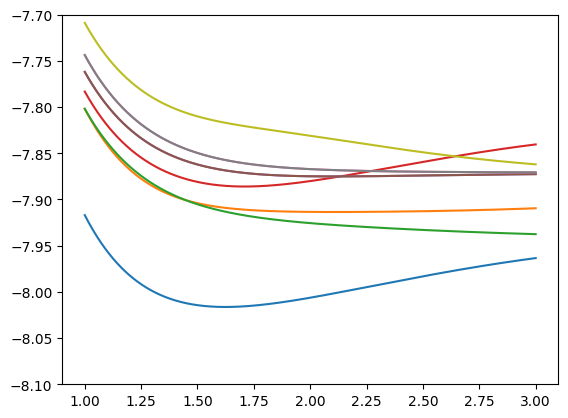

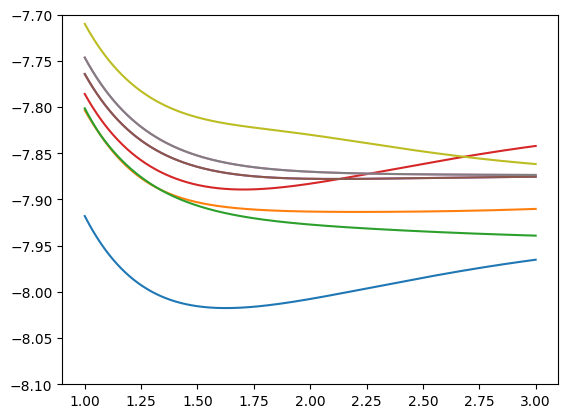

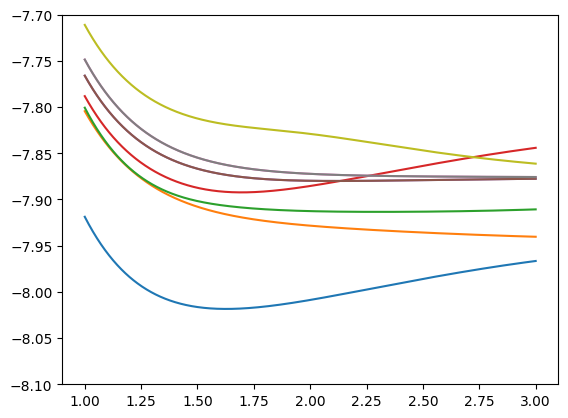

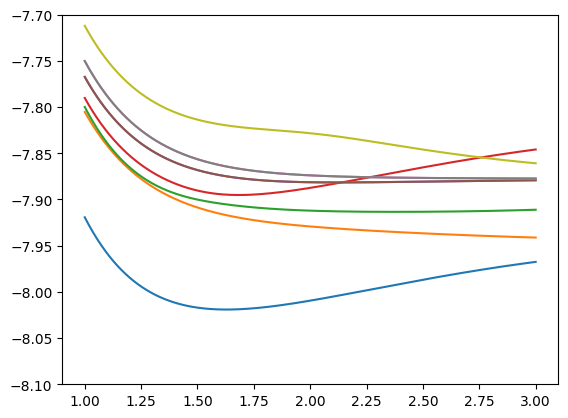

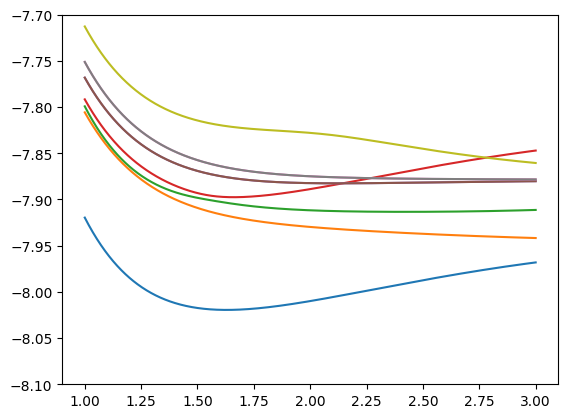

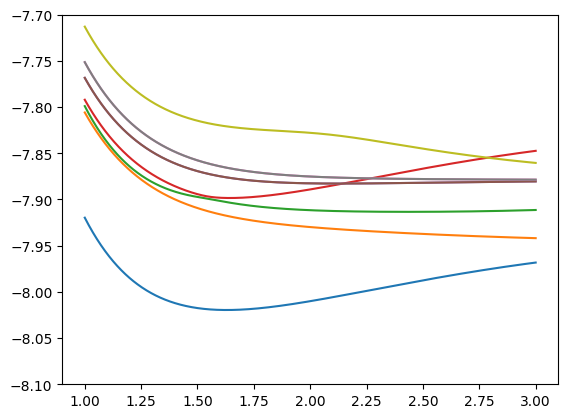

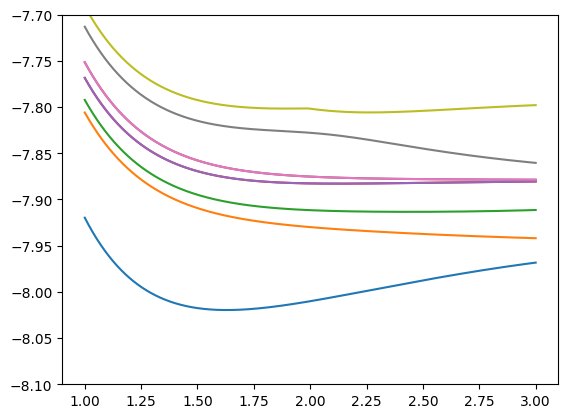

In [10]:

d_0_05_reshaped= np.zeros_like(cavity_E_array_0_05)
print(d_0_05_reshaped.shape)

def vector_magnitude(vector):
    return np.sqrt(vector[0]**2 + vector[1]**2 + vector[2]**2)


for q in range(d_0_05.shape[3]):
    for i in range(d_0_05.shape[0]):
        for j in range(d_0_05.shape[1]):
            if i == j:
                d_0_05_reshaped[q][i] = vector_magnitude(d_0_05[i,i,:,q])

plt.plot(d_0_05_reshaped)
plt.show()



print(np.diff(d_0_05_reshaped[:, 1]))
print(np.diff(d_0_05_reshaped[:, 2]))


plt.plot(np.diff(d_0_05_reshaped[:, 1]))
plt.plot(np.diff(d_0_05_reshaped[:, 2]))
plt.show()

In [ ]:
discontinuity_threshold_std  = 2

dipole_array1  = d_0_05_reshaped[:, 1]

dipole_array2 = d_0_05_reshaped[:, 2]

dipoles_diff_1 = np.diff(dipole_array1)
dipoles_diff_2 = np.diff(dipole_array2)

mean_1 = np.mean(dipoles_diff_1)
mean_2 = np.mean(dipoles_diff_2)

std_1 = np.std(dipoles_diff_1)
std_2 = np.std(dipoles_diff_2)


discontinuity_threshold_pos =  mean_1 + (std_1*discontinuity_threshold_std)
discontinuity_threshold_neg =  mean_1 - (std_1*discontinuity_threshold_std)
idx_1 = np.sort(np.concatenate([ np.where( dipoles_diff_1 >  discontinuity_threshold_pos )[0]+1 ,  np.where( dipoles_diff_1 <  discontinuity_threshold_neg )[0]+1 ]))

discontinuity_threshold_pos =  mean_2 + (std_2*discontinuity_threshold_std)
discontinuity_threshold_neg =  mean_2 - (std_2*discontinuity_threshold_std)
idx_2 = np.sort(np.concatenate([ np.where( dipoles_diff_2 >  discontinuity_threshold_pos )[0]+1 ,  np.where( dipoles_diff_2 <  discontinuity_threshold_neg )[0]+1 ]))




print(idx_1)
print(idx_2)


In [ ]:
# cavity_E_array_0_05  = declutter_E_array(cavity_E_array_0_05,d_0_05, r_data, 2, 4,num_to_declutter=9)
# plt.plot(r_data, cavity_E_array_0_05 )
# plt.ylim(-8.1,-7.7)
# plt.show()

In [ ]:


#cavity_free_E_array = declutter_E_array(cavity_free_E_array,np.zeros_like(cavity_free_E_array), r_data, 1 , 1 ,num_to_declutter=9)
# cavity_E_array_0_1  = declutter_E_array(cavity_E_array_0_1,r_data, i, 4-i,num_to_declutter=9)
# cavity_E_array_0_08  = declutter_E_array(cavity_E_array_0_08,r_data,i, 4-i,num_to_declutter=9)
# cavity_E_array_0_1  = declutter_E_array(cavity_E_array_0_1,r_data, i, 4-i,num_to_declutter=9)
# cavity_E_array_0_08  = declutter_E_array(cavity_E_array_0_08,r_data, i, 4-i,num_to_declutter=9)
# cavity_E_array_0_06  = declutter_E_array(cavity_E_array_0_06,r_data, i, 4-i,num_to_declutter=9)
cavity_E_array_0_05  = declutter_E_array(cavity_E_array_0_05,d_0_05, r_data, 2, 4,num_to_declutter=9)
cavity_E_array_0_04  = declutter_E_array(cavity_E_array_0_04,d_0_04, r_data, 3, 7,num_to_declutter=9)
cavity_E_array_0_03  = declutter_E_array(cavity_E_array_0_03,d_0_03, r_data, 3, 7,num_to_declutter=9)
cavity_E_array_0_02  = declutter_E_array(cavity_E_array_0_02,d_0_02, r_data, 3, 7,num_to_declutter=9)
cavity_E_array_0_01  = declutter_E_array(cavity_E_array_0_01,d_0_01, r_data, 3, 7,num_to_declutter=9)
cavity_E_array_0_005  = declutter_E_array(cavity_E_array_0_005,d_0_005, r_data, 3, 7,num_to_declutter=9)

In [ ]:

plt.plot(r_data, cavity_E_array_0_05 )
plt.ylim(-8.1,-7.7)
plt.show()
plt.plot(r_data, cavity_E_array_0_04 )
plt.ylim(-8.1,-7.7)
plt.show()
plt.plot(r_data, cavity_E_array_0_03 )
plt.ylim(-8.1,-7.7)
plt.show()
plt.plot(r_data, cavity_E_array_0_02 )
plt.ylim(-8.1,-7.7)
plt.show()
plt.plot(r_data, cavity_E_array_0_01 )
plt.ylim(-8.1,-7.7)
plt.show()
plt.plot(r_data, cavity_E_array_0_005 )
plt.ylim(-8.1,-7.7)
plt.show()
plt.plot(r_data,cavity_free_E_array)
plt.ylim(-8.1,-7.7)
plt.show()

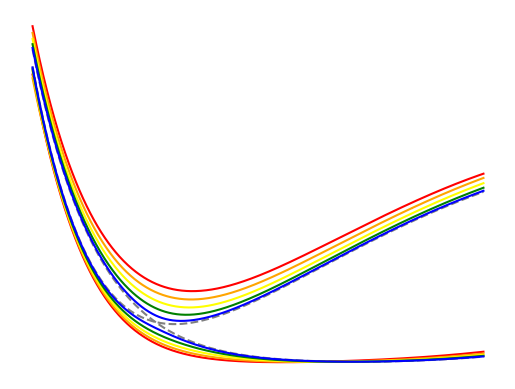

In [15]:


LP_0_005 = cavity_E_array_0_005[:, 2]
UP_0_005 = cavity_E_array_0_005[:, 3]
LP_0_01 = cavity_E_array_0_01[:, 2]
UP_0_01 = cavity_E_array_0_01[:, 3]
LP_0_02 = cavity_E_array_0_02[:, 2]
UP_0_02 = cavity_E_array_0_02[:, 3]
LP_0_03 = cavity_E_array_0_03[:, 2]
UP_0_03 = cavity_E_array_0_03[:, 3]
LP_0_04 = cavity_E_array_0_04[:, 2]
UP_0_04 = cavity_E_array_0_04[:,3]
LP_0_05 = cavity_E_array_0_05[:, 2]
UP_0_05 = cavity_E_array_0_05[:, 3]
# LP_0_06 = cavity_E_array_0_06[:, 1]
# UP_0_06 = cavity_E_array_0_06[:, 3]
# LP_0_08 = cavity_E_array_0_08[:, 1]
# UP_0_08 = cavity_E_array_0_08[:, 3]
# LP_0_1 = cavity_E_array_0_1[:, 1]
# UP_0_1 = cavity_E_array_0_1[:, 3]




fci_S0 = cavity_free_E_array[:,0]
fci_S1 = cavity_free_E_array[:,2]
triplet_state = cavity_free_E_array[:, 1]
plt.plot(r_data, fci_S0 + 0.12086, color = 'grey', linestyle = 'dashed')
plt.plot(r_data, fci_S1, 'grey', linestyle = 'dashed')
#plt.plot(r_data, triplet_state , 'purple', linestyle = 'dashed')
# plt.plot(r_data, LP_0_1)
# plt.plot(r_data, UP_0_1)
# plt.plot(r_data, LP_0_08)
# plt.plot(r_data, UP_0_08)
# plt.plot(r_data, LP_0_06)
# plt.plot(r_data, UP_0_06)
plt.plot(r_data, LP_0_05)
plt.plot(r_data, UP_0_05)
plt.plot(r_data, LP_0_04)
plt.plot(r_data, UP_0_04)
plt.plot(r_data, LP_0_03)
plt.plot(r_data, UP_0_03)
plt.plot(r_data, LP_0_02)
plt.plot(r_data, UP_0_02)
plt.plot(r_data, LP_0_01)
plt.plot(r_data, UP_0_01)
plt.show()

In [ ]:
fci_S0 = cavity_free_E_array[:,0]
fci_S1 = cavity_free_E_array[:,2]
plt.plot(r_data, fci_S0 + 0.111, color = 'grey', linestyle = 'dashed')
plt.plot(r_data, fci_S1, 'grey', linestyle = 'dashed')
plt.show()

In [ ]:
print(np.argmin(fci_S0))

In [ ]:

hbar = 1

# number of grid points 
N = 2001


def get_fd_wfn(x, V_y: np.array, use_5_point_stencil = False):

    hbar = 1


    # define grid spacing h
    h = x[1]-x[0]

    # create arrays for T, V, and H - we truncate the smallest and largest grid points where 
    # the centered finite difference derivatives cannot be defined
    T = np.zeros((N-2, N-2))
    V = np.zeros((N-2, N-2))
    H = np.zeros((N-2, N-2))

    # this uses the 3 point stencil; we can adapt to use a 5 point and it might improve accuracy


    if not use_5_point_stencil:
        for i in range(N-2):
            for j in range(N-2):
                if i==j:
                    T[i,j]= -2
                elif np.abs(i-j)==1:
                    T[i,j]=1
                else:
                    T[i,j]=0

        T = -T *( hbar ** 2 / (2 * mu_au* h**2))
        #T =  (- (hbar ** 2) / (2* mu_kg)) *  (1 / ( h**2)) * joule_to_hartree  * T


    elif use_5_point_stencil:
        for i in range(N-2):
            for j in range(N-2):
                if i==j:
                    T[i,j]= -30
                elif np.abs(i-j)==1:
                    T[i,j]=16
                elif np.abs(i-j)==2:
                    T[i,j]=-1

        T = -T *  ((hbar ** 2) / (2* mu_au))*  (1 / ( 12 * h**2)) 


    for i in range(N-2):
        for j in range(N-2):
            if i==j:
                V[i,j]= V_y[i+1]
            else:
                V[i,j]=0
                
    H = T + V

    #print((-T * hbar ** 2 / (2 * mu_kg* h**2)) * (2.294 * 10 ** 17))
    #print(V)

    vals, vecs = np.linalg.eigh(H)

    if np.average(vecs[:, 0]) < 0:
        vecs = vecs * -1

    return vals, vecs

In [ ]:
#FCF calculator
def get_fcf_matrix(potential_1, potential_2, r_data, matrix_size = 6, potential_1_is_groundstate = False):

    #geneerate 2 sets of wavefunctions for the potentials

    r_data_au = r_data / psi4.constants.bohr2angstroms

    min_potential_1_loc = np.argmin(potential_1[:])
    r_eq_au =r_data_au[potential_1.argmin()]

    print("r_eq_au : " , r_eq_au)


    # Fitting S0 PES to a quintic polynomial

    poly = np.poly1d(np.polyfit(r_data_au, potential_1, 7))

    poly_array = np.asarray(poly)


    #Taking first and second derivative of S0 PES and evaluating at r_eq
    first_derivative = poly.deriv()
    second_derivative = first_derivative.deriv()
    k_au = second_derivative(r_eq_au)
    print("k_au: ", k_au)


    angstrom_to_bohr = 1.88973
    x_min = r_data_au[0]
    x_max = r_data_au[-1]

    hbar = 1

    # number of grid points 
    N = 2001
    # define grid
    x = np.linspace(x_min, x_max, N)

    V_y = np.polyval(np.asarray(poly), (x))


    vals1, vecs1 = get_fd_wfn(x, V_y, use_5_point_stencil=True)
    #vals1, vecs1 = get_fd_wfn(x, V_y)



    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('bond length (m)')
    ax1.set_ylabel('wfn', color=color)
    ax1.plot(x[1:N-1], vecs1[:,0], 'r', label = "$\psi_0$")
    ax1.plot(x[1:N-1], vecs1[:,1], 'b',label = "$\psi_1$" )
    ax1.plot(x[1:N-1], vecs1[:,2], 'g',label = "$\psi_2$")
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('energy (hartree)', color=color)  # we already handled the x-label with ax1
    ax2.plot(r_data_au, potential_1, 'bo', label='PES_1')
    ax2.plot(r_data_au, poly(r_data_au), 'm-', label='fit')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    fig.legend()
    plt.show()


    min_potential_2_loc = np.argmin(potential_2[:])
    r_eq_au =r_data_au[min_potential_2_loc]

    print("r_eq_au : " , r_eq_au)


    # Fitting S0 PES to a quintic polynomial

    #can use this line to only fit to bottom of well for cubic and harmonic
    #poly = np.poly1d(np.polyfit(r_data_meters[50:100], fci_S0[50:100], 4))

    poly = np.poly1d(np.polyfit(r_data_au, potential_2, 7))

    poly_array = np.asarray(poly)


    #Taking first and second derivative of S0 PES and evaluating at r_eq
    first_derivative = poly.deriv()
    second_derivative = first_derivative.deriv()
    k_au = second_derivative(r_eq_au)
    print("k_au: ", k_au)


    angstrom_to_bohr = 1.88973
    x_min = r_data_au[0]
    x_max = r_data_au[-1]

    hbar = 1

    # number of grid points 
    N = 2001
    # define grid
    x = np.linspace(x_min, x_max, N)

    V_y = np.polyval(np.asarray(poly), (x))


    vals2, vecs2 = get_fd_wfn(x, V_y, use_5_point_stencil=True)
    #vals2, vecs2 = get_fd_wfn(x, V_y)



    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('bond length')
    ax1.set_ylabel('wfn', color=color)
    ax1.plot(x[1:N-1], vecs2[:,0], 'r',label = "$\psi_0$")
    ax1.plot(x[1:N-1], vecs2[:,1], 'b',label = "$\psi_1$")
    ax1.plot(x[1:N-1], vecs2[:,2], 'g', label = "$\psi_2$")

    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('energy (hartree)', color=color)  # we already handled the x-label with ax1
    ax2.plot(r_data_au, potential_2, 'bo', label='PES_2')
    ax2.plot(r_data_au, poly(r_data_au), 'm-', label='fit')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    fig.legend()
    plt.show()


    FCF_matrix = np.zeros((matrix_size,matrix_size))

    for i in range(FCF_matrix.shape[0]):
        for j in range(FCF_matrix.shape[0]):

            FCF_matrix[i][j] = np.trapz(vecs1[:,i] * vecs2[:,j]) 
            FCF = np.absolute(FCF_matrix) ** 2 

    return FCF




In [ ]:

fcf_0_05 = get_fcf_matrix(fci_S0,UP_0_05, r_data, 6)

fcf_0_04 = get_fcf_matrix(fci_S0,UP_0_04, r_data, 6)

fcf_0_03 = get_fcf_matrix(fci_S0,UP_0_03, r_data, 6)

fcf_0_02 = get_fcf_matrix(fci_S0,UP_0_02, r_data, 6)

fcf_0_01 = get_fcf_matrix(fci_S0,UP_0_01, r_data, 6)
fcf_0_005 = get_fcf_matrix(fci_S0,UP_0_005, r_data, 6)

In [ ]:
min_val, max_val = 0, 15
cm = sns.light_palette("blue", as_cmap=True)
x=pd.DataFrame(fcf_0_005)
x=x.style.background_gradient(cmap=cm)
display(x)

min_val, max_val = 0, 15
cm = sns.light_palette("blue", as_cmap=True)
x=pd.DataFrame(fcf_0_01)
x=x.style.background_gradient(cmap=cm)
display(x)

min_val, max_val = 0, 15
cm = sns.light_palette("blue", as_cmap=True)
x=pd.DataFrame(fcf_0_02)
x=x.style.background_gradient(cmap=cm)
display(x)

min_val, max_val = 0, 15
cm = sns.light_palette("blue", as_cmap=True)
x=pd.DataFrame(fcf_0_03)
x=x.style.background_gradient(cmap=cm)
display(x)

min_val, max_val = 0, 15
cm = sns.light_palette("blue", as_cmap=True)
x=pd.DataFrame(fcf_0_04)
x=x.style.background_gradient(cmap=cm)
display(x)

min_val, max_val = 0, 15
cm = sns.light_palette("blue", as_cmap=True)
x=pd.DataFrame(fcf_0_05)
x=x.style.background_gradient(cmap=cm)
display(x)

In [ ]:
td_0_005 = np.load("/Users/proden/Code/npy_files/LiH_cs_5_photons/cs_5_photons_fci_dipoles_LIH_6311g0_005.npy")[0,3,:,314]
td_0_01 = np.load("/Users/proden/Code/npy_files/LiH_cs_5_photons/cs_5_photons_fci_dipoles_LIH_6311g0_01.npy")[0,3,:,314]
td_0_02 = np.load("/Users/proden/Code/npy_files/LiH_cs_5_photons/cs_5_photons_fci_dipoles_LIH_6311g0_02.npy")[0,3,:,314]
td_0_03 = np.load("/Users/proden/Code/npy_files/LiH_cs_5_photons/cs_5_photons_fci_dipoles_LIH_6311g0_03.npy")[0,3,:,314]
td_0_04 = np.load("/Users/proden/Code/npy_files/LiH_cs_5_photons/cs_5_photons_fci_dipoles_LIH_6311g0_04.npy")[0,3,:,314]
td_0_05 = np.load("/Users/proden/Code/npy_files/LiH_cs_5_photons/cs_5_photons_fci_dipoles_LIH_6311g0_05.npy")[0,3,:,314]
td_0_1 = np.load("/Users/proden/Code/npy_files/LiH_cs_5_photons/cs_5_photons_fci_dipoles_LIH_6311g0_1.npy")[0,3,:,314]




def vector_magnitude(vector):
    return np.sqrt(vector[0]**2 + vector[1]**2 + vector[2]**2)


td_0_005 = vector_magnitude(td_0_005)**2
td_0_01 = vector_magnitude(td_0_01)**2
td_0_02 = vector_magnitude(td_0_02)**2
td_0_03 = vector_magnitude(td_0_03)**2
td_0_04 = vector_magnitude(td_0_04)**2
td_0_05 = vector_magnitude(td_0_05)**2
td_0_1= vector_magnitude(td_0_1)**2


print(td_0_005)
print(td_0_01)
print(td_0_02)
print(td_0_03)
print(td_0_04)
print(td_0_05)
print(td_0_1)


In [ ]:
min_val, max_val = 0, 15
cm = sns.light_palette("blue", as_cmap=True)
x=pd.DataFrame(td_0_005*fcf_0_005)
x=x.style.background_gradient(cmap=cm)
display(x)

min_val, max_val = 0, 15
cm = sns.light_palette("blue", as_cmap=True)
x=pd.DataFrame(td_0_01*fcf_0_01)
x=x.style.background_gradient(cmap=cm)
display(x)

min_val, max_val = 0, 15
cm = sns.light_palette("blue", as_cmap=True)
x=pd.DataFrame(td_0_02*fcf_0_02)
x=x.style.background_gradient(cmap=cm)
display(x)

min_val, max_val = 0, 15
cm = sns.light_palette("blue", as_cmap=True)
x=pd.DataFrame(td_0_03 * fcf_0_03)
x=x.style.background_gradient(cmap=cm)
display(x)

min_val, max_val = 0, 15
cm = sns.light_palette("blue", as_cmap=True)
x=pd.DataFrame(td_0_04* fcf_0_04)
x=x.style.background_gradient(cmap=cm)
display(x)

min_val, max_val = 0, 15
cm = sns.light_palette("blue", as_cmap=True)
x=pd.DataFrame(td_0_05 * fcf_0_05)
x=x.style.background_gradient(cmap=cm)
display(x)

print(x.to_html())
